<a href="https://www.kaggle.com/code/senazey/fish-classification?scriptVersionId=203106298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import os

Here we're reading the dataset into a data frame that includes two columns: paths to the images in the dataset and the labels of the images.

In [2]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 

label=[]
path=[]

for dirname, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png' and dirname.split()[-1]!='GT':
            label.append(os.path.split(dirname)[-1])
            path.append(os.path.join(dirname,filename))
            
data = pd.DataFrame(columns=['path', 'label'])
data['path']=path
data['label']=label

# **ANALYSING THE DATA**

Let's show the distribution of the data.

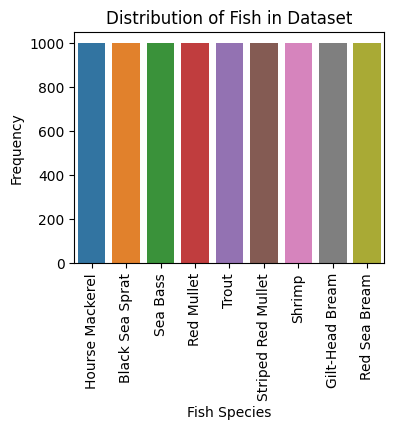

In [3]:
data['label'].value_counts()
plt.figure(figsize = (4,3))
sns.countplot(x=data['label'])
plt.title("Distribution of Fish in Dataset")
plt.xlabel("Fish Species")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

# **PREPROCESSING THE IMAGES**

Here we're loading the images into an img array and then transforming them into values between 0 and 1. Then we split X and y values: X is the preprocessed images and y is the labels of the corresponding image.

In [4]:
def load_and_preprocess(df, target_size=(64,64)):
    images=[]
    for index, row in df.iterrows():
        img = tf.keras.preprocessing.image.load_img(row['path'], target_size=target_size)  
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  
        images.append(img_array)
    return np.array(images)


X = load_and_preprocess(data)

y = data['label'].values

In [5]:
lb = LabelBinarizer()
y=lb.fit_transform(y)
print(y.shape)

(9000, 9)


After splitting the images and their labels, we encoded the labels.

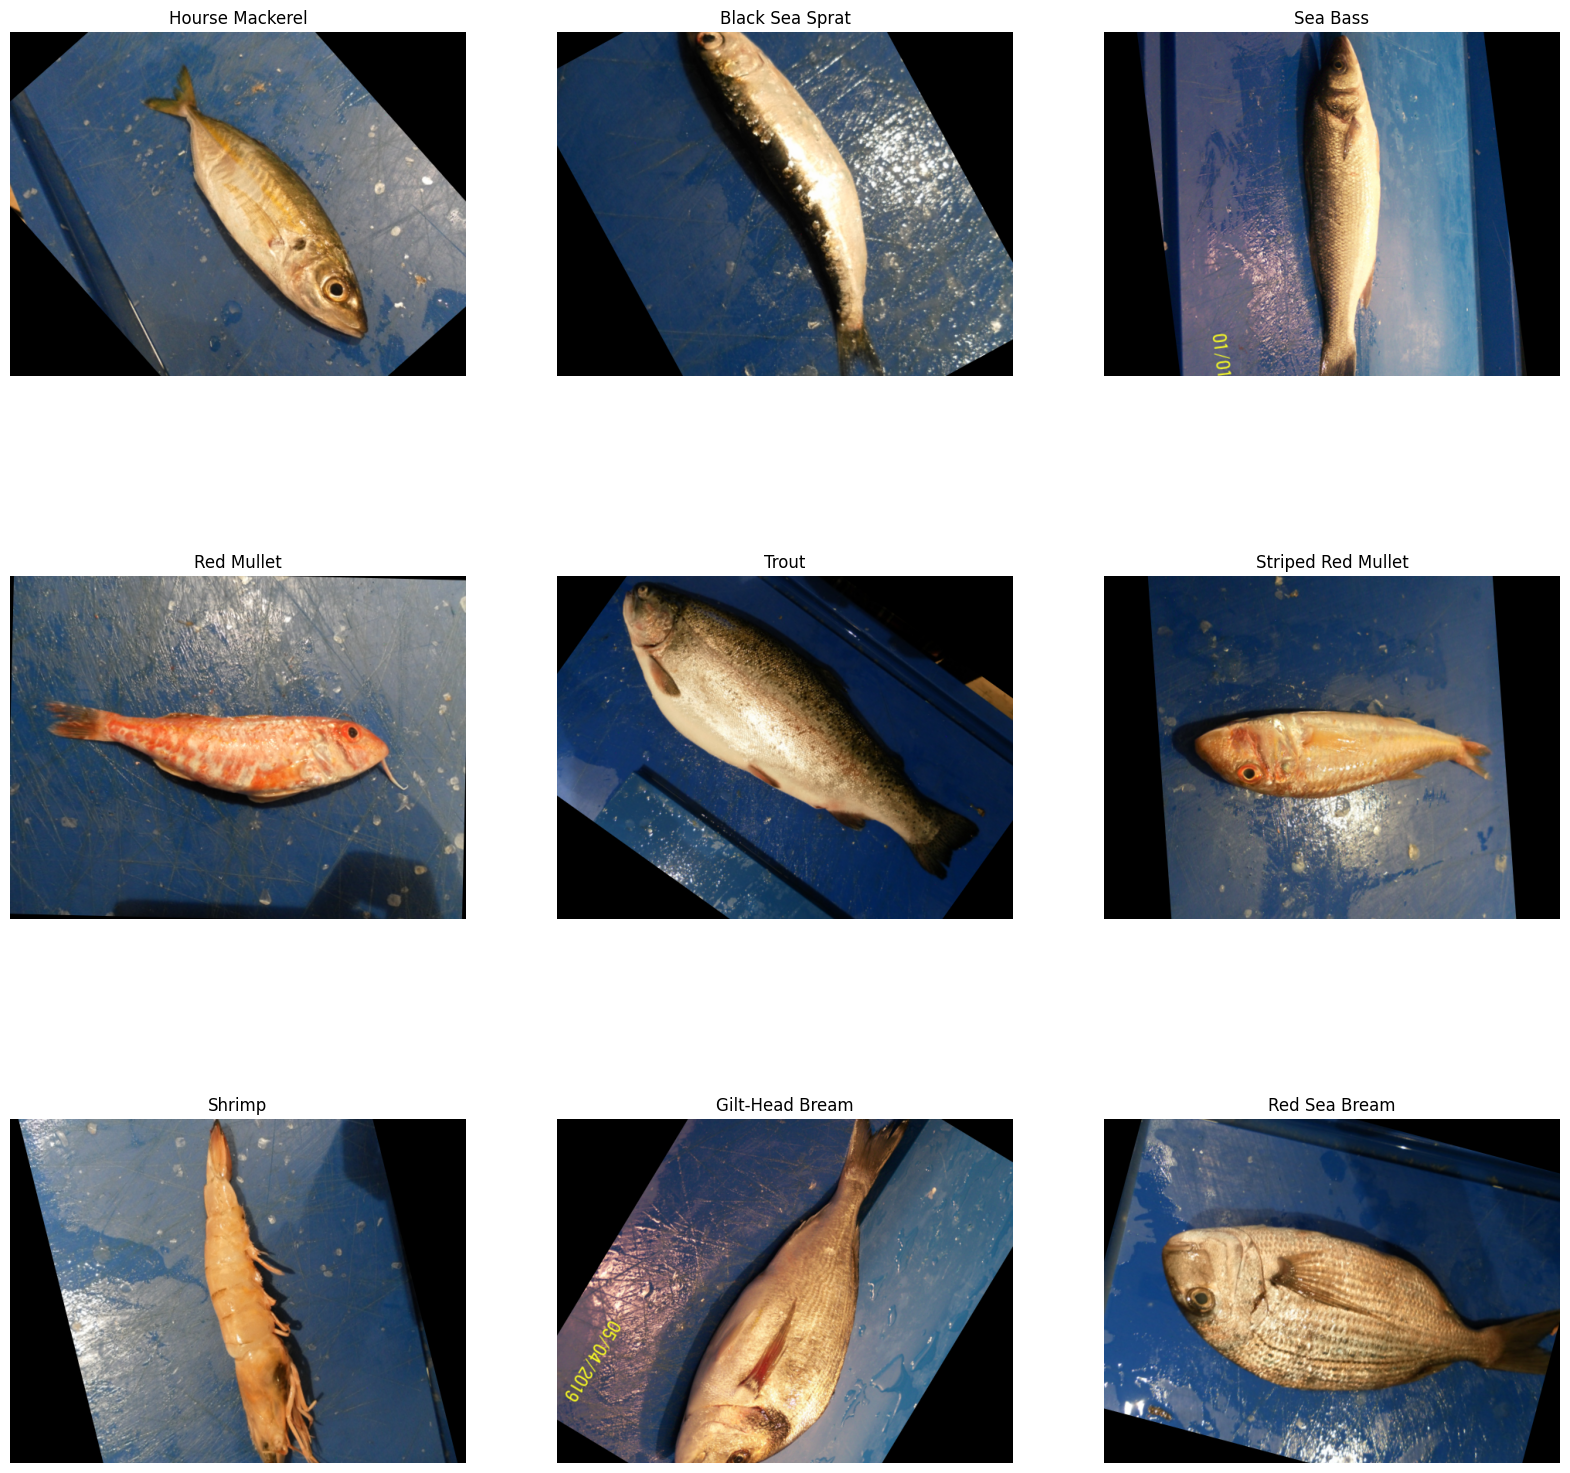

In [6]:
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(plt.imread(data['path'][i*1000]))
    plt.title(data['label'][i*1000])
    plt.axis('off')
plt.show()

Showing an example from each fish species.

# SPLITTING AND FLATTENING THE DATA


In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  
print(y_train.shape)  
print(y_val.shape)   

(5400, 9)
(1800, 9)


Train data: %60
Test data: %20
Validation data: %20

In [8]:
X_train = X_train.reshape(X_train.shape[0], -1) 
X_val = X_val.reshape(X_val.shape[0], -1)       
X_test = X_test.reshape(X_test.shape[0], -1)      
print(X_train.shape)

(5400, 12288)


# HYPERPARAMETER OPTIMIZATION

In [9]:
def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),  
    tf.keras.layers.Dense(256, activation='relu'),                                   
    tf.keras.layers.Dense(len(lb.classes_), activation='softmax') 
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def random_search(X_train, y_train, param_dict, n_iter=10):
    best_score=0
    best_params={}
    
    for i in range(n_iter):
        params={
            'epochs': np.random.choice(param_dict['epochs']),
            'batch_size': np.random.choice(param_dict['batch_size']),
            'optimizer': np.random.choice(param_dict['optimizer'])
        }
        
        model = create_model(params['optimizer'])
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        
        score = model.evaluate(X_val, y_val, verbose=0)[1]
        
        if score > best_score:
            best_score = score
            best_params = params
        
        return best_score, best_params
    

In [10]:
param_dict = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 60],
    'optimizer': ['adam', 'rmsprop', 'sgd']
}

In [11]:
best_score, best_params = random_search(X_train, y_train, param_dict, n_iter=10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model = create_model(optimizer=best_params['optimizer'])
results = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val))


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2875 - loss: 1.9313 - val_accuracy: 0.5633 - val_loss: 1.3531
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5462 - loss: 1.3201 - val_accuracy: 0.5867 - val_loss: 1.1546
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6362 - loss: 1.0553 - val_accuracy: 0.6561 - val_loss: 1.0592
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7054 - loss: 0.8866 - val_accuracy: 0.7183 - val_loss: 0.8507
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7478 - loss: 0.7552 - val_accuracy: 0.6822 - val_loss: 0.8787
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7906 - loss: 0.6350 - val_accuracy: 0.7583 - val_loss: 0.6898
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8232 - loss: 0.5408 - val_accuracy: 0.8211 - val_loss: 0.5521
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8454 - loss: 0.4874 - val_accu

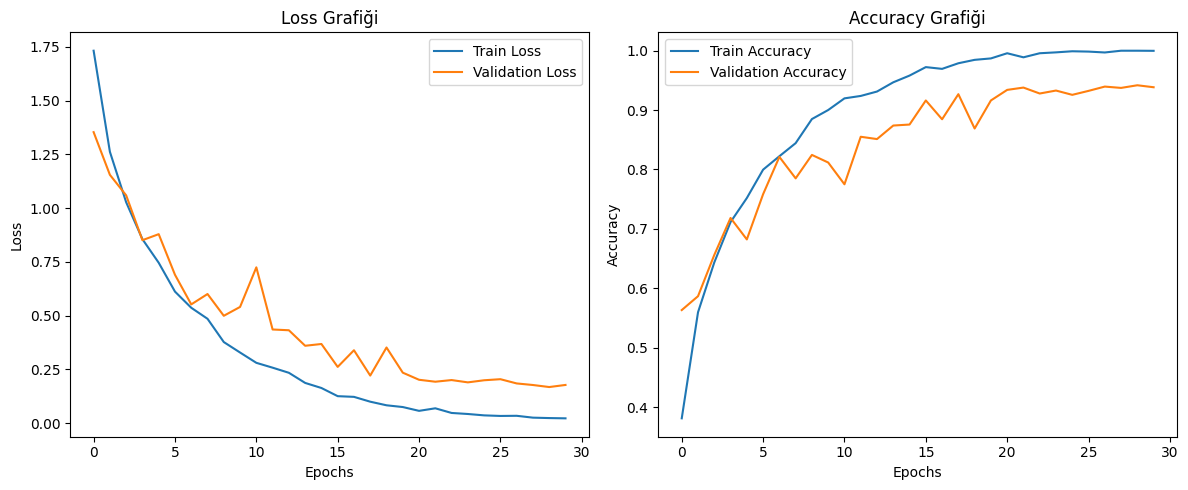

In [13]:
# Şimdi train ve validation setlerinin performanslarını karşılaştıralım.

# Figürü oluşturuyoruz.
plt.figure(figsize=(12, 5))

# Loss değeri için grafikleri çizdirelim.
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy score grafikleri çizdirelim.
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Test Loss:', test_loss)
print('Accuracy Score:', test_accuracy)

Test Loss: 0.18190079927444458
Accuracy Score: 0.9438889026641846
